# Overall Strategy
1. First filter the molecules by their proximal distance to the protein.
2. For the molecules with contacts over the bound, filter for the protein residues identities that they are in contact with.
3. Sort through this second list of lists for those that also remain over the bound.
4. Renumber of resid of this module according to the chain and resid of the protein

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import distances as mdaDist
import numpy as np
from collections import Counter
from multiprocessing import Pool
import multiprocessing
from itertools import product
import pprint
import os, glob

In [2]:
#setting the run directory
os.chdir('/home/miro/Documents/water_contacts/dynamic_network_analysis_scripts/..')
os.getcwd()


'/home/miro/Documents/water_contacts'

In [3]:
# = = = Time-keeping functions. TQDM is a simple progress bar that works in both Jupyter Notebook and terminals.
import time


In [4]:
bPythonScriptExport=False

In [5]:
n_cores=multiprocessing.cpu_count()

In [6]:
os.getcwd()


'/home/miro/Documents/water_contacts'

In [7]:
# = = = Plotting results
if bPythonScriptExport:
    import matplotlib
    matplotlib.use('pdf')
else:
    %matplotlib inline
    #%matplotlib notebook
from matplotlib import pyplot as plt
import networkx as nx
from networkx.drawing.nx_pylab import draw_networkx

In [8]:
if bPythonScriptExport:
    import argparse
    parser = argparse.ArgumentParser(description='Identify stable protein and water/chloride contact pairs in a trajectory',
                                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--psf', type=str, dest='psfFile', default='seg.psf',
                        help='The name of the protein structure file.')
    parser.add_argument('--trj', type=str, dest='trjFile', default='small.xtc',
                        help='The name of the trajectory file.')
    parser.add_argument('--out', type=str, dest='outputPrefix', default='contactPairs',
                        help='A prefix for all output files generated.')
    parser.add_argument('--sel', type=str, dest='selectionText', default='name OW and resname SOL',
                        help='An MDAnalysis selection text that chooses one atom of each solvent residue to compute contacts from.'
                       'Examples: "name CL" and "name OW and resname SOL". Solvent residue indices are often non-unique.')    
    parser.add_argument('-r', type=float, dest='ratioCutoff', default=1.00,
                        help='Minimum fraction of simulation frames pairs must be in contact.')
    parser.add_argument('-k', type=int, dest='numKeepCutoff', default=None,
                        help='(WIP) Alternative to the above, keep N waters with the most persistent contacts, regardless of cutoff.')
    parser.add_argument('-d', type=float, dest='distCutoff', default=5.0,
                        help='Maximum separation for pairs to be considered in contact.')
    parser.add_argument('--in_mem', action='store_true', dest='bInMemory',
                        help='Asks MDAnlaysis to load the entire trajectory into memory.')
    args = parser.parse_args()
    
    ratioCutoff  = args.ratioCutoff
    distCutoff   = args.distCutoff
    outputPrefix = args.outputPrefix
    psfFile      = args.psfFile
    trjFile      = args.trjFile
    bInMemory    = args.bInMemory
    solvSelText  = args.selectionText

In [9]:
if not bPythonScriptExport:
    ratioCutoff=0.25 ; distCutoff = 3.5
    filePathPrefix='./trajectories'
    allele='wt' ; temperature='310K' ; replicate=1
    sourceFolder='%s/%s/%s/%i' % (filePathPrefix, allele, temperature, replicate)
    psfFile='%s/seg.psf' % sourceFolder
    trjFile='%s/small.xtc' % sourceFolder
    bInMemory    = True
    solvSelText  = "name OW and resname SOL"
    #outputPrefix=sourceFolder+'contactPairs_SOL'
    outputPrefix=os.path.join(sourceFolder,'contactPairs_SOL_%g_%g' % ( ratioCutoff, distCutoff ) )
    print(outputPrefix)
    #solvSelText  = "name CL"
    #outputPrefix=sourceFolder+'contactPairs_CL'    

./trajectories/wt/310K/1/contactPairs_SOL_0.25_3.5


In [10]:
def filter_unique_residues( atomSel ):
    #return np.unique(atomSel.resids)
    listExtendednameString = []
    for x,y,z in zip(atomSel.segids, atomSel.resnames, atomSel.resids):
        listExtendednameString.append( x+":"+y+":"+str(z) )
    return np.unique( listExtendednameString )

In [11]:
#def count_indices_of_selection_over_trajectory(u, selectionText,frame_arr):
def count_indices_of_selection_over_trajectory(arg_str):
    u=mda.Universe(arg_str[0],arg_str[1])
    selectionText=arg_str[2]
    frame_arr=arg_str[3]
    l=[]
    
    atomSel = u.select_atoms(selectionText, updating=True)
    print("= = (Time accounting) Looking for contacts using selection text: %s" % selectionText )
    print("    ...Starting at: %s" % time.ctime())
    #for f in tqdm(range(u.trajectory.n_frames)):
    #for f in (range(u.trajectory.n_frames)):
    print(str(len(list(range(frame_arr[0],frame_arr[1])))))
    #+1 is needed so it gets the last frame in the slice, range is a weird function in python 3
    for f in (range(frame_arr[0],frame_arr[1])):
        u.trajectory[f]
        l.extend(atomSel.indices)
    print("   Finished at: %s" % time.ctime() )
    return Counter(l)

In [12]:
#returns a number of arrays (n_tasks) with a total of num_frames elements. Each array has roughly an 
#equal number of elements with some having an extra frame in order to make sure we don't miss frames
def distribute_frames_amongst_cores(num_frames, n_tasks):                                           #make handy little array we can refer back to of all the frame numbers
    frames_arr=range(num_frames)
    #we're going to divide the tasks into blocks of roughly equal sizes, smallest size is gonna be something roughly equal to the lowest  
    min_block_size=int(num_frames/n_tasks)

    #make array of size of blocks, these will denote the number of frames assigned to each core
    blocks=[min_block_size]*n_tasks

    #adjust some block sizes so we cover all the frames
    temp=0
    while np.sum(blocks)<num_frames:
        blocks[temp]=blocks[temp]+1
        temp=temp+1

    #make blank array to store block start and end indexes
    inds=np.zeros([n_tasks,2])

    #actually calculating the start and end point of the blocks
    row_index=0
    running_index=0
    while running_index<num_frames:
        inds[row_index,0]=running_index
        running_index=running_index+blocks[row_index]
        inds[row_index,1]=running_index
        row_index=row_index+1
    #dealing with type issues
    inds=[[int(x1),int(x2)] for [x1,x2] in inds]
    return inds    

In [13]:
def search_close_protein(sel_str):
    dictSelContacts={} ; dictProteinNearby={}
    print(sel_str)
    #a = u.select_atoms("protein and around %f index %i" % (distCutoff, x[0]), updating=True)
    a = u.select_atoms(sel_str, updating=True)
    
    #!!!!!SUPER JANK NEED TO FIX!!!!!
    #split up the input string to figure out the index
    
    index=int(sel_str.split()[-1])
    
    dictSelContacts[index] = a
    print(a)
    #dictProteinNearby[x[0]] = []
    return(dictSelContacts)

In [14]:
def decide_contact_residues(arg_arr):
    frame_arr=[arg_arr[0][0],arg_arr[0][1]]
    
    dictSelContacts=arg_arr[1]
    dictProteinNearby=arg_arr[2]

    
    for f in (range(frame_arr[0],frame_arr[1])):
          u.trajectory[f]
          for i in dictSelContacts.keys():
              listUniqueResidues = filter_unique_residues(dictSelContacts[i])              
          dictProteinNearby[i].extend( listUniqueResidues )
    return dictProteinNearby

In [15]:
#pass a list of strings to the select atoms function above, we use a list of strings like this 
#so we can parralalelise the operation.
def obtain_protein_contacts_of_highest_counts(u, counter, ratioCutoff, distCutoff,ntasks):
    # = = = Setup relevant dictionaries
    count=0
    minCounts = ratioCutoff*u.trajectory.n_frames
    dictSelContacts={} ; dictProteinNearby={}
    sel_arr=[]

    for x in counter.most_common():
        if x[1]>=minCounts:
             sel_arr.append("protein and around " +str(distCutoff) + " index " +str(x[0]))

    #         a = u.select_atoms("protein and around %f index %i" % (distCutoff, x[0]), updating=True)
    #         a = u.select_atoms("protein and around %f index %i" % (distCutoff, x[0]), updating=True)
#             dictSelContacts[x[0]] = a
#             dictProteinNearby[x[0]] = []
#        else:
#           break
    
    print("    ...Starting at: %s" % time.ctime() )

    if __name__=="__main__":
        with Pool(processes=ntasks) as p:   
            temp_dictSelContacts=p.map(search_close_protein,sel_arr)
    print("    Finished at: %s" % time.ctime() )
    print(temp_dictSelContacts)
    for d in temp_dictSelContacts:
       dictSelContacts.update(d)
    frames_arr=distribute_frames_amongst_cores(num_frames,ntasks)
    arg_arr=[]
    
    print('dictSelContacts ')
    print(dictSelContacts)
    
    dictProteinNearby=dictSelContacts
    
    dictProteinNearby = dict.fromkeys(dictProteinNearby, [])
    
    for i in range(ntasks):
        arg_arr.append([frames_arr[i],dictSelContacts,dictProteinNearby])
    print(arg_arr)    

    
    if __name__=="__main__":
        with Pool(processes=ntasks) as p:
            temp_dictProteinNearby=p.map(decide_contact_residues,arg_arr)

#     print("= = (Time accounting) Looking for protein contacts of indices with highest occupancy")
#     print("    ...Starting at: %s" % time.ctime() )
#     for f in (range(u.trajectory.n_frames)):
#          u.trajectory[f]
#          for i in dictSelContacts.keys():
#              listUniqueResidues = filter_unique_residues( dictSelContacts[i] )
#              dictProteinNearby[i].extend( listUniqueResidues )
#     print("   intermediate %s" % time.ctime() )

#     # = = = Convert list of protein resid occurrences to python Counter
#     for i in dictProteinNearby.keys():
#         dictProteinNearby[i] = Counter( dictProteinNearby[i] )
#     print("    Finished at: %s" % time.ctime() )

    
    for i in dictProteinNearby.keys():
        dictProteinNearby[i] = Counter( dictProteinNearby[i] )     
    
    return dictProteinNearby

In [16]:
def convert_contacts_to_edgelist(u, dictCounters, ratioCutoff=0.0):
    edgeList=[]
    minCounts = ratioCutoff*u.trajectory.n_frames
    for i in dictCounters.keys():
        for p in dictCounters[i].most_common():
            if p[1]>=minCounts:
                nameA = "Index_%i" % i
                edgeList.append( (nameA, p[0], p[1]/u.trajectory.n_frames) )
            else:
                break
    return edgeList

In [17]:
def print_edgelist(fileName, edgeList):
    fp = open(fileName,'w')
    for a,b,c in edgeList:
        print(a,b,c, file=fp)
    fp.close()
    
def print_graph(fileName, edgeList):
    delta=0.1 ; nCols=3
    G = nx.Graph(name='Contact pairs')    
    for x in edgeList:
        G.add_edge(x[0],x[1],weight=x[2])
    subGraphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    nSub=len(subGraphs) ; nRows=int(np.ceil(nSub/nCols))
    if nSub < nCols:
        fig = plt.figure(figsize=(8, 6))
        wEdges = [G.edges[x]['weight'] for x in G.edges() ] 
        draw_networkx(G, font_size=9, node_color='white',
                      edge_color=wEdges, style='dashed')
        axThis = fig.get_axes()[0]
        xLim = axThis.get_xlim() ; axThis.set_xlim( xLim[0]-delta, xLim[1]+delta )
        yLim = axThis.get_ylim() ; axThis.set_ylim( yLim[0]-delta, yLim[1]+delta )
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(fileName)
        return   
    
    fig, axes = plt.subplots(nRows,nCols, figsize=(4*nCols, 4*nRows) )
    for i in range(nSub):
        ii = int(i/nCols) ; jj = i % nCols
        axThis = axes[ii,jj]
        wEdges = [subGraphs[i].edges[x]['weight'] for x in subGraphs[i].edges() ] 
        draw_networkx(subGraphs[i], ax=axThis, font_size=9, node_color='white',
                      edge_color=wEdges, style='dashed')
        xLim = axThis.get_xlim() ; axThis.set_xlim( xLim[0]-delta*2, xLim[1]+delta*2 )
        yLim = axThis.get_ylim() ; axThis.set_ylim( yLim[0]-delta, yLim[1]+delta )
        axThis.set_axis_off()
    plt.tight_layout()
    plt.savefig(fileName)

In [18]:
u = mda.Universe(psfFile, trjFile)
num_frames=u.trajectory.n_frames


/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


In [19]:
#u.trajectory.coordinate_array.shape

In [20]:
ntasks=n_cores
#ntasks=8
frame_inds=distribute_frames_amongst_cores(num_frames,ntasks)
print(frame_inds)

[[0, 13], [13, 26], [26, 39], [39, 52], [52, 65], [65, 77], [77, 89], [89, 101]]


In [21]:
sel_str= ("%s and around %g protein" % (solvSelText, distCutoff))
arg_str=[]
for i in range(len(frame_inds)):
    arg_str.append([psfFile,trjFile,sel_str,frame_inds[i]])
                
if __name__=='__main__':
    with Pool(processes=ntasks) as p:                                                              
        counters=p.map(count_indices_of_selection_over_trajectory,arg_str)
#gotta add them up because this actually makes n_tasks counters.
counterNearbyWaters=np.sum(counters)


/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/lib/distances.py:715: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gridsearch = FastNS(max_cutoff, configuration, box=box)
/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/lib/distances.py:715: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


= = (Time accounting) Looking for contacts using selection text: name OW and resname SOL and around 3.5 protein
    ...Starting at: Fri Aug  6 09:06:00 2021
13
= = (Time accounting) Looking for contacts using selection text: name OW and resname SOL and around 3.5 protein= = (Time accounting) Looking for contacts using selection text: name OW and resname SOL and around 3.5 protein
    ...Starting at: Fri Aug  6 09:06:00 2021

13= = (Time accounting) Looking for contacts using selection text: name OW and resname SOL and around 3.5 protein    ...Starting at: Fri Aug  6 09:06:00 2021


12
    ...Starting at: Fri Aug  6 09:06:01 2021
= = (Time accounting) Looking for contacts using selection text: name OW and resname SOL and around 3.5 protein13
= = (Time accounting) Looking for contacts using selection text: name OW and resname SOL and around 3.5 protein
    ...Starting at: Fri Aug  6 09:06:01 2021

13
    ...Starting at: Fri Aug  6 09:06:01 2021
12
= = (Time accounting) Looking for contac

In [22]:
print(counterNearbyWaters)

Counter({82058: 101, 90746: 101, 94583: 101, 114002: 101, 117437: 101, 128378: 101, 135053: 101, 138404: 101, 158087: 101, 188300: 100, 109853: 99, 133184: 98, 109523: 97, 109550: 97, 111896: 97, 84782: 96, 132707: 96, 109577: 95, 155642: 95, 129830: 94, 153128: 94, 137078: 94, 111836: 93, 128282: 93, 144452: 93, 152636: 93, 89711: 93, 112667: 92, 125060: 92, 129947: 91, 152915: 91, 153932: 91, 76043: 90, 122927: 90, 165887: 90, 109721: 90, 129983: 89, 125390: 88, 132674: 88, 169385: 88, 156053: 88, 64073: 87, 73256: 87, 112091: 86, 162206: 85, 169937: 85, 92792: 85, 158435: 83, 177722: 83, 160940: 83, 80720: 82, 170216: 82, 145556: 82, 126998: 80, 129758: 79, 73058: 79, 88349: 79, 161570: 78, 64913: 78, 85931: 78, 111869: 77, 111947: 77, 120089: 77, 138413: 76, 65207: 76, 173975: 76, 138854: 76, 79883: 74, 109310: 73, 99767: 72, 113981: 71, 105689: 71, 71777: 71, 102305: 70, 144440: 70, 129959: 70, 117896: 70, 100916: 68, 114071: 67, 92027: 67, 77327: 67, 112373: 66, 132770: 66, 17343

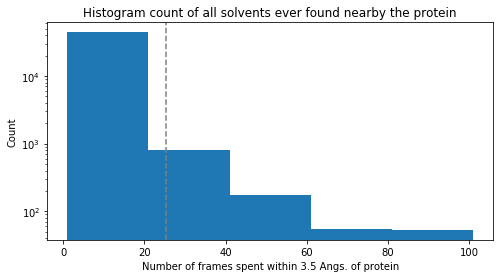

In [23]:
vals = np.array([ x[1] for x in counterNearbyWaters.most_common() ])
#print( counterNearbyWaters.most_common())
plt.figure(figsize=(8, 4))
plt.hist(vals, bins=int(u.trajectory.n_frames/20))
plt.axvline(x=u.trajectory.n_frames*ratioCutoff, color='grey', linestyle='--', label='Persistence cutoff ratio.')
plt.yscale('log')
plt.title('Histogram count of all solvents ever found nearby the protein')
plt.xlabel('Number of frames spent within %g Angs. of protein' % distCutoff); plt.ylabel('Count')
plt.savefig(outputPrefix+'_histogram.pdf')

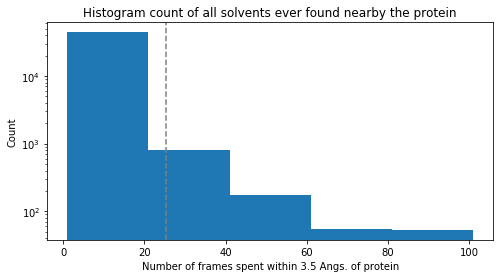

In [24]:
vals = np.array([ x[1] for x in counterNearbyWaters.most_common() ])
#print( counterNearbyWaters)
plt.figure(figsize=(8, 4))
plt.hist(vals, bins=int(u.trajectory.n_frames/20))
plt.axvline(x=u.trajectory.n_frames*ratioCutoff, color='grey', linestyle='--', label='Persistence cutoff ratio.')
plt.yscale('log')
plt.title('Histogram count of all solvents ever found nearby the protein')
plt.xlabel('Number of frames spent within %g Angs. of protein' % distCutoff); plt.ylabel('Count')
plt.savefig(outputPrefix+'_histogram.pdf')

In [25]:
#dictProteinsNearbyWater = obtain_protein_contacts_of_highest_counts(u, counterNearbyWaters, ratioCutoff, distCutoff, ntasks)
#temp_counter=np.sum(counterNearbyWaters.most_common(10))

def do_subset(counter, lst):
    return Counter({k: counter.get(k, 0) for k in lst})

lst=[x[0] for x in counterNearbyWaters.most_common(10)]
temp_counter=do_subset(counterNearbyWaters,lst)

print(temp_counter)

dictProteinsNearbyWater = obtain_protein_contacts_of_highest_counts(u, counterNearbyWaters, ratioCutoff, distCutoff, ntasks)


Counter({82058: 101, 90746: 101, 94583: 101, 114002: 101, 117437: 101, 128378: 101, 135053: 101, 138404: 101, 158087: 101, 188300: 100})
    ...Starting at: Fri Aug  6 09:06:38 2021
protein and around 3.5 index 144179protein and around 3.5 index 128207protein and around 3.5 index 149885protein and around 3.5 index 177722protein and around 3.5 index 71777protein and around 3.5 index 144452
protein and around 3.5 index 173048






/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/core/selection.py:728: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/core/selection.py:728: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
/hom

/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/core/selection.py:728: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/core/selection.py:728: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


protein and around 3.5 index 82058


/home/miro/miniconda3/lib/python3.9/site-packages/MDAnalysis/core/selection.py:728: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


<AtomGroup [<Atom 6349: HE1 of type HE1 of resname MET, resid 348 and segid TD1>]><AtomGroup []>

protein and around 3.5 index 113558
protein and around 3.5 index 160940<AtomGroup [<Atom 733: O of type O of resname GLN, resid 39 and segid LAS>, <Atom 737: HA of type HA of resname ILE, resid 40 and segid LAS>, <Atom 16167: HA of type HA of resname ALA, resid 1087 and segid TD2>, <Atom 16229: HD2 of type HD2 of resname PHE, resid 1090 and segid TD2>, <Atom 16239: HB1 of type HB1 of resname LEU, resid 1091 and segid TD2>]>

protein and around 3.5 index 90746
<AtomGroup []>
protein and around 3.5 index 155243
<AtomGroup []>
protein and around 3.5 index 102305
<AtomGroup []><AtomGroup [<Atom 16428: HG2 of type HG2 of resname GLN, resid 1100 and segid TD2>]>
<AtomGroup [<Atom 12350: OE1 of type OE1 of resname GLU, resid 873 and segid TD2>, <Atom 13232: HA of type HA of resname LEU, resid 926 and segid TD2>]>protein and around 3.5 index 102314


protein and around 3.5 index 152636protein and 

<AtomGroup [<Atom 3517: HB2 of type HB2 of resname ASP, resid 192 and segid TD1>, <Atom 3530: CG of type CG of resname GLU, resid 193 and segid TD1>, <Atom 3531: HG1 of type HG1 of resname GLU, resid 193 and segid TD1>, <Atom 3532: HG2 of type HG2 of resname GLU, resid 193 and segid TD1>, <Atom 3533: CD of type CD of resname GLU, resid 193 and segid TD1>, <Atom 3535: OE2 of type OE2 of resname GLU, resid 193 and segid TD1>, <Atom 16211: HH2 of type HH2 of resname TRP, resid 1089 and segid TD2>]>
protein and around 3.5 index 125060
<AtomGroup []>
protein and around 3.5 index 58841
<AtomGroup [<Atom 9067: O of type O of resname ILE, resid 507 and segid ND1>, <Atom 9087: O of type O of resname PHE, resid 508 and segid ND1>, <Atom 9100: HB of type HB of resname VAL, resid 510 and segid ND1>, <Atom 10026: HD2 of type HD2 of resname LYS, resid 564 and segid ND1>, <Atom 15830: HD1 of type HD1 of resname PHE, resid 1068 and segid TD2>, <Atom 15862: HE of type HE of resname ARG, resid 1070 and 

In [ ]:
print(dictProteinNearby[188300])

In [ ]:
print(dictProteinsNearbyWater)

In [ ]:
edgeListWater = convert_contacts_to_edgelist(u, dictProteinsNearbyWater, ratioCutoff)

In [ ]:
print_edgelist(outputPrefix+'.txt', edgeListWater)

In [ ]:
print_graph(outputPrefix+'_graph.pdf', edgeListWater)